In [33]:
# OpenAI Gym
import gym_tetris as gym
import gym.spaces
import numpy as np
import keras
import cv2

# Rendering tools
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import clear_output

(108, 82, 3)

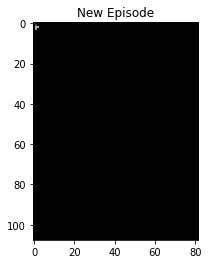

In [34]:
# Load the cart-pole environment
env = gym.make('Tetris-v0')

downsize = (82,108)

# Reinitialize the environment for an episode
observation = env.reset()
observation = cv2.resize(observation, dsize=downsize, interpolation = cv2.INTER_CUBIC)
# Look at the features the agent will observe during training...
display(observation.shape)

# Render the scene for our visualization purposes...
#plt.imshow(env.render(mode='rgb_array'))
#plt.title("New Episode") 
#plt.show()
plt.imshow(observation)
plt.title("New Episode")
plt.show()

In [35]:
# Shape of the observation vectors
display(observation.shape)

# Number of possible actions
display(env.action_space.n)

(108, 82, 3)

12

In [36]:

# Initialize the environment and perform 10 random actions
env.reset()
reward = 0.0
#for time in range(100):
#    plt.imshow(cv2.resize(env.render(mode='rgb_array'),dsize=downsize,interpolation = cv2.INTER_CUBIC))
#    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
#    clear_output(wait=True)
#    display(plt.gcf())
#    observation, reward, done, info = env.step(np.random.choice(env.action_space.n)) # take a random action
#    if (done):
#        break
clear_output(wait=True)

In [39]:
# A simple multilayer architecture....
def make_model(state, action_size):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(128, kernel_size=(8, 8), activation='relu',
                                    input_shape=[downsize[0],
                                    downsize[1],
                                    state.shape[2]]))
    model.add(keras.layers.Conv2D(128, (8, 8), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(action_size, activation='linear'))
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.001))
    return model

model = make_model(cv2.resize(env.reset(), dsize=downsize, interpolation = cv2.INTER_CUBIC), env.action_space.n)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 75, 101, 128)      24704     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 68, 94, 128)       1048704   
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 34, 47, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 34, 47, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 204544)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                4090900   
_________________________________________________________________
dense_12 (Dense)             (None, 12)                252       
Total para

In [40]:
# Turn our observation vector into a matrix of observations
# with only -one- observation and run predict()
Q = model.predict(np.expand_dims(cv2.resize(observation, dsize=(108,82), interpolation = cv2.INTER_CUBIC),axis=0))
Q

array([[ 0.03019561, -0.005526  ,  0.01544973,  0.04807615, -0.06312497,
         0.0613861 ,  0.06354961, -0.02301501, -0.04012189, -0.03241936,
        -0.03056934, -0.01775178]], dtype=float32)

In [41]:
np.argmax(Q)

6

In [42]:
# Example e-soft policy...
epsilon = 0.5 # Half of the time, a random action is chosen...
action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
action

7

In [43]:

# Initialize the environment and let the agent decide!
observation = env.reset()
observation = cv2.resize(observation, dsize=downsize, interpolation = cv2.INTER_CUBIC)
epsilon = 1 # No exploration!
reward = 0.0
#for time in range(50):
#    plt.imshow(env.render(mode='rgb_array'))
#    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
#    clear_output(wait=True)
#    display(plt.gcf())
#    Q = model.predict(np.expand_dims(observation,axis=0)) # Compute Q
#    action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
#    observation, reward, done, info = env.step(action) # take action!
#    if (done):
#        break
#clear_output(wait=True)

In [44]:

# Step 1 - Replay Memory Class
class ReplayMemory:
    def __init__(self, memory_size, state_size, action_size):
        self.state_size = [state_size.shape[0], state_size.shape[1], state_size.shape[2]]
        self.action_size = action_size
        self.size = 0
        self.maxsize = memory_size
        self.current_index = 0
        #self.current_state = np.zeros([memory_size, self.state_size[0], self.state_size[1], 
        #                               self.state_size[2]])
        self.current_state = np.zeros([memory_size, 
                                       82, 
                                       108, 
                                       self.state_size[2]])
        self.action = [0]*memory_size # Remember, actions are integers...
        self.reward = np.zeros([memory_size])
        self.next_state = np.zeros([memory_size, self.state_size[0], self.state_size[1], 
                                       self.state_size[2]])
        self.done = [False]*memory_size # Boolean (terminal transition?)
        
    def remember(self, current_state, action, reward, next_state, done):
        # Stores a single memory item
        self.current_state[self.current_index,:] = current_state
        self.action[self.current_index] = action
        self.reward[self.current_index] = reward
        self.next_state[self.current_index,:] = next_state
        self.done[self.current_index] = done
        self.current_index = (self.current_index+1)%self.maxsize
        self.size = max(self.current_index,self.size)
    
    def replay(self, model, target_model, num_samples, sample_size, gamma):
        # Run replay!
        
        # Can't train if we don't yet have enough samples to begin with...
        if self.size < sample_size:
            return
        
        for i in range(num_samples):
            # Select sample_size memory indices from the whole set
            current_sample = np.random.choice(self.size,sample_size,replace=False)
            
            # Slice memory into training sample
            current_state = self.current_state[current_sample,:]
            action = [self.action[j] for j in current_sample]
            reward = self.reward[current_sample]
            next_state = self.next_state[current_sample,:]
            done = [self.done[j] for j in current_sample]
            
            # Obtain model's current Q-values
            #
            #
            # Here's the issue 
            # model_targets, targets, model.fit will require valid game state to make prediction
            #
            #
            if current_state.size == 425700:
                model_targets = model.predict(cv2.resize(current_state, dsize=(108,82), interpolation = cv2.INTER_CUBIC))
                # Create targets from argmax(Q(s+1,a+1))
                # Use the target model!
                print(next_state.size)
                targets = reward + gamma*np.amax(target_model.predict(next_state,axis=1))

                # Absorb the reward on terminal state-action transitions
                targets[done] = reward[done]
                # Update just the relevant parts of the model_target vector...
                model_targets[range(sample_size),action] = targets

                # Update the weights accordingly
                model.fit(cv2.resize(current_state, dsize=downsize, interpolation = cv2.INTER_CUBIC),model_targets,
                          epochs=1,verbose=0,batch_size=sample_size)
            else:
                continue
            
        # Once we have finished training, update the target model
        target_model.set_weights(model.get_weights())

In [45]:

# Full setup for the task...

# For keeping track of performance
from collections import deque

# Hyperparameters
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.991
epsilon_min = 0.01
episodes = 1000

replay_iterations = 100
replay_sample_size = 256

# Peformance stats
times_window = deque(maxlen=100)
mean_times = deque(maxlen=episodes)

# Initialize the environment and agent data structures
env = gym.make('Tetris-v0')
model = make_model(cv2.resize(env.reset(), dsize=(108,82), interpolation = cv2.INTER_CUBIC), env.action_space.n)
target_model = make_model(cv2.resize(env.reset(), dsize=(108,82), interpolation = cv2.INTER_CUBIC), env.action_space.n)
memory = ReplayMemory(5000, cv2.resize(env.reset(), dsize=(108,82), interpolation = cv2.INTER_CUBIC), env.action_space.n)

In [55]:
episodes = 263
done = False
# Perform the training!
for episode in range(episodes):
    current_state = env.reset()
    reward_earned = 0
    #for time in range(2000):
    time = 0
    while not done:
        Q = model.predict(np.expand_dims(cv2.resize(current_state, dsize=(108,82), interpolation = cv2.INTER_CUBIC), axis=0)) # Compute Q
        action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
        next_state, reward, done, info = env.step(action) # take action!
        next_state = cv2.resize(next_state, dsize=(108,82), interpolation = cv2.INTER_CUBIC)
        if done:
            reward -= 10.0
            reward_earned -= 10.0
            if time < mean_time:
                reward -= 20.0
                reward_earned -= 20.0
            else:
                reward += 10.0
                reward_earned += 10.0
        reward += 0.02
        reward_earned += 0.02
        if current_state.size == 425700:
            resize_state = cv2.resize(current_state, dsize=(108,82), interpolation = cv2.INTER_CUBIC)
            memory.remember(resize_state, action,reward,next_state,done) # Store in memory...
        current_state = next_state # Transition to next state!
        time += 1
    #    if (done):
    #        break
    epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
    times_window.append(time)
    mean_time = np.mean(times_window)
    mean_times.append(mean_time)
    print('\rEpisode %d/%d - time: %d, mean-time: %d, epsilon: %f, reward: %g'%(episode+1,episodes,time,mean_time,epsilon,reward_earned),end='')
    time = 0
    done = False
    
    # Training...
    memory.replay(model,target_model,replay_iterations,replay_sample_size,gamma)
print()

Episode 33/263 - time: 1159, mean-time: 1282, epsilon: 0.086290, reward: -6.82

KeyboardInterrupt: 

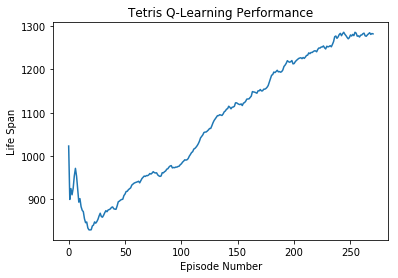

In [56]:

# Plot results
plt.plot(mean_times)
plt.title("Tetris Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Life Span")
plt.show()

In [57]:
model.save_weights('weights.h5')

In [17]:
model.load_weights('weights.h5')

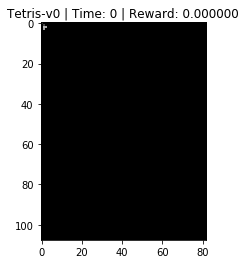

AssertionError: Cannot call env.step() before calling reset()

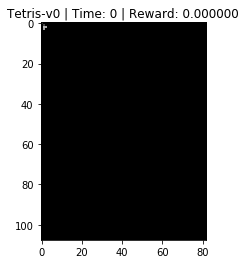

In [31]:

# Test out the agent!
# Initialize the environment and let the agent decide how to act!
for time in range(1300):
    plt.imshow(cv2.resize(env.render(mode='rgb_array'),dsize=downsize,interpolation = cv2.INTER_CUBIC))
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    Q = model.predict(np.expand_dims(cv2.resize(observation,dsize=(108,82),interpolation = cv2.INTER_CUBIC),axis=0))
    action = np.argmax(Q)
    observation, reward, done, info = env.step(action)
    if (done):
        break
clear_output(wait=True)

In [53]:
#Run this when display surface quit
env = gym.make('Tetris-v0')
observation = env.reset()